In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from pandas.plotting import scatter_matrix

from scipy import stats

from util import as_numpy

# Steam Regression Analysis

## Steam Games Dataset

The Steam dataset originates from https://data.world/craigkelly/steam-game-data and was created by Craig Kelly. The dataset includes ownership data on around 12,000 videogames on the Steam digital distribution platform, and features such as genre, full text descriptions (written by the publisher/developer of the game), descriptive tags, supported languages, release dates, and reviewer scores. I'm interested in this dataset because I intend to publish a game within the next few years and I'm curious as to whether or not certain features are correlated with game popularity.

Model performance will be compared using RMSE.

In [93]:
steam = pd.read_csv("data/games-features.csv")
steam.sample(4)

,QueryID,ResponseID,QueryName,ResponseName,ReleaseDate,RequiredAge,DemoCount,DeveloperCount,DLCCount,Metacritic,...,LegalNotice,Reviews,SupportedLanguages,Website,PCMinReqsText,PCRecReqsText,LinuxMinReqsText,LinuxRecReqsText,MacMinReqsText,MacRecReqsText
6899,381780,381780,80 Days,80 Days,Sep 28 2015,0,0,2,0,84,...,(c) 2014 inkle Ltd,80 Days tells a wonderful unpredictable story ...,English**languages with full audio support,http://www.inklestudios.com/80days,Minimum:OS: Windows XP+Processor: 2 Ghz with S...,Recommended:OS: Windows XP+Processor: 4 Ghz wi...,,,Minimum:OS: OS X 10.7+Processor: 2 Ghz with SS...,Recommended:OS: OS X 10.7+Processor: 4 Ghz wit...
7348,393320,393320,Typing Instructor Platinum 21,Typing Instructor Platinum 21,Jan 26 2016,0,0,1,0,0,...,,,English* Spanish**languages with full audio su...,http://www.individualsoftware.com/?product=typ...,Minimum:OS: 10 8.1 8 7 XPProcessor: NoneMemory...,,,,,
4936,333690,333690,Epanalepsis,Epanalepsis,May 21 2015,0,0,1,2,48,...,,,English,http://epanalepsis.com/,Minimum:OS: Windows XP SP 3 / Vista / 7 / 8Pro...,,Minimum:OS: Ubuntu 12.04 or higherProcessor: 1...,,Minimum:OS: OS X 10.7 or laterProcessor: Intel...,
2186,234330,234330,Marvel Puzzle Quest,Marvel Puzzle Quest,Dec 5 2013,0,0,1,3,0,...,(c) MARVELPUZZLE QUEST(tm) AND THE ASSOCIATED ...,An intricately crafted remarkably deep experie...,English* French* Italian* German* Spanish* Jap...,http://d3go.com/games/marvelpuzzlequest/,Minimum:OS: Windows XP SP3Processor: Intel Pen...,,,,,


In [4]:
steam.columns

Index(['QueryID', 'ResponseID', 'QueryName', 'ResponseName', 'ReleaseDate',
       'RequiredAge', 'DemoCount', 'DeveloperCount', 'DLCCount', 'Metacritic',
       'MovieCount', 'PackageCount', 'RecommendationCount', 'PublisherCount',
       'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
       'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance',
       'AchievementCount', 'AchievementHighlightedCount', 'ControllerSupport',
       'IsFree', 'FreeVerAvail', 'PurchaseAvail', 'SubscriptionAvail',
       'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin',
       'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec',
       'MacReqsHaveMin', 'MacReqsHaveRec', 'CategorySinglePlayer',
       'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
       'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
       'CategoryIncludeLevelEditor', 'CategoryVRSupport', 'GenreIsNonGame',
       'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 'GenreIsCasual',
       'G

In [136]:
steam[['HeaderImage']].sample(10)

,HeaderImage
10535,http://cdn.akamai.steamstatic.com/steam/apps/4...
1893,http://cdn.akamai.steamstatic.com/steam/apps/2...
11631,http://cdn.akamai.steamstatic.com/steam/apps/5...
12594,http://cdn.akamai.steamstatic.com/steam/apps/5...
642,http://cdn.akamai.steamstatic.com/steam/apps/4...
9846,http://cdn.akamai.steamstatic.com/steam/apps/4...
6858,http://cdn.akamai.steamstatic.com/steam/apps/3...
2354,http://cdn.akamai.steamstatic.com/steam/apps/2...
8507,http://cdn.akamai.steamstatic.com/steam/apps/4...
181,http://cdn.akamai.steamstatic.com/steam/apps/6...


In [70]:
steam.shape

(13357, 78)

In [7]:
steam['PriceCurrency'].value_counts()

USD    10739
        2618
Name: PriceCurrency, dtype: int64

In [8]:
steam['ResponseName'].value_counts().head(30)

Train Simulator 2016                              9
Jewel Quest Pack                                  7
Jagged Alliance 2 Gold                            5
SiN Episodes: Emergence                           5
F.E.A.R.                                          5
Mahjong Quest Collection                          5
Cake Mania Collection                             5
Tom Clancys Rainbow Six(r) Siege                  5
Crazy Machines 1.5                                5
BRINK                                             5
RIP - Trilogy(tm)                                 5
Westward Collection                               5
Super Granny Collection                           5
Tradewinds Classics                               5
Crysis Warhead(r)                                 3
Shank                                             3
Portal 2                                          3
The Sims(tm) 3                                    3
Civilization IV: Beyond the Sword                 3
Trine 2: Com

In [9]:
#steam['ExtUserAcctNotice'].value_counts()
#steam['DRMNotice'].value_counts()
#steam['Background'].value_counts()
#steam['HeaderImage'].value_counts()
#steam['Reviews'].value_counts()
#steam['PCMinReqsText'].value_counts()
steam['ReleaseDate'].value_counts()

Aug 22 2016      241
Aug 26 2016      152
                  87
Sep 9 2016        77
Sep 7 2016        68
                ... 
Mar 19 2012        1
Oct 1 2012         1
Sep 25 2008        1
Early October      1
Mar 27 2007        1
Name: ReleaseDate, Length: 2117, dtype: int64

### Notes on Steam dataset

Category is already encoded.

It looks like all prices are in USD, though some are unlabeled I'm just going to assume that they are USD and the webscraper didn't retrieve them correctly.

For now textual descriptions such as Background, AboutText, SupportedLanguages, and MinReqsText will all be removed as I do not yet know how to perform a bag-of-words or word-vector style feature decomposition on these. I will probably add them back in later when I've done more research on ohw to do this.

Links like Background or HeaderImage will also be removed.

Note that these removed columns probably do actually contain very valuable data to making an accurate prediction, it's just that I currently do not know how to incorporate them into regression and/or it would be infeasible to donwload the content of all of these links for 40,000 examples in a short amount of time. I might come back to that though??

There appear to be duplicate games??? I'll have to think of a creative way to merge these.

In [120]:
def steam_clean(df):
    ret = df.drop(labels=[
        'QueryID', # These are just related to webscraping
        'ResponseID',
        'QueryName',
        'ResponseName', # Could be useful for 'catchiness' or 'length', but that's a whole can of worms
        'SupportEmail',
        'SupportURL',
        'Background', # All 4 of these actually contain a LOT of data, but again, analyzing sequential text data is hard.
        'ShortDescrip',
        'DetailedDescrip',
        'AboutText',
        'PriceCurrency', # Assumed to be USD
        'DRMNotice', # useful to convert to boolean value
        'ExtUserAcctNotice', # useful to convert to boolean value
        'HeaderImage', # boolean
        'LegalNotice', # boolean
        'Reviews', # boolean
        'SupportedLanguages', # Could separate up into a series of encoded variables, remove for now
        'Website', # boolean
        'PCMinReqsText', # All of these could have sentiment analysis done on them
        'PCRecReqsText',
        'LinuxMinReqsText',
        'LinuxRecReqsText',
        'MacMinReqsText',
        'MacRecReqsText',
        'SteamSpyPlayersEstimate', # The next three are dead giveaways and would give the model too much information.
        'SteamSpyPlayersVariance',
        'SteamSpyOwnersVariance', # Maybe could be incorporated into evaluation in some way
    ], axis=1)
    
    ret['ReleaseDate'] = pd.to_datetime(ret['ReleaseDate'], errors='coerce')
    
    # I would rather remove games that have no release date rather than impute them. Knowing steam, they probably aren't released yet, and imputation makes no sense here.
    # I might replace it with iterative imputation, but as it stands I'm losing like 400 games out of the 40,000 samples. I'd rather just not train on them.
    ret.dropna(subset=['ReleaseDate'], inplace=True)
    
    ret['ReleaseYear'] = pd.DatetimeIndex(ret['ReleaseDate']).year
    ret['ReleaseMonth'] = pd.DatetimeIndex(ret['ReleaseDate']).month
    ret['ReleaseDay'] = pd.DatetimeIndex(ret['ReleaseDate']).day
    ret = ret.drop(['ReleaseDate'], axis=1)
    
    # Remove outliers
    #print(ret.shape)
    #z = ret[ret.select_dtypes(include=['int64', 'float64']).columns]
    #z = ret['SteamSpyOwners']
    #z = np.abs(stats.zscore(z))
    #ret = ret[(z < 5).all(axis=1)]
    #z = (z < 3).all(axis=1)
    #z = (z < 3)
    return ret

steam_cleaned = steam_clean(steam)
steam_cleaned.head() # MINDBLOWINGLY, SHOCKINGLY CLEAN
steam_cleaned.shape

(12872, 53)

In [78]:
steam_cleaned.dtypes

RequiredAge                      int64
DemoCount                        int64
DeveloperCount                   int64
DLCCount                         int64
Metacritic                       int64
MovieCount                       int64
PackageCount                     int64
RecommendationCount              int64
PublisherCount                   int64
ScreenshotCount                  int64
SteamSpyOwners                   int64
AchievementCount                 int64
AchievementHighlightedCount      int64
ControllerSupport                 bool
IsFree                            bool
FreeVerAvail                      bool
PurchaseAvail                     bool
SubscriptionAvail                 bool
PlatformWindows                   bool
PlatformLinux                     bool
PlatformMac                       bool
PCReqsHaveMin                     bool
PCReqsHaveRec                     bool
LinuxReqsHaveMin                  bool
LinuxReqsHaveRec                  bool
MacReqsHaveMin           

In [121]:
steam_viz = steam_cleaned[steam_cleaned.select_dtypes(include=['int64', 'float64']).columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f731ff494d0>,
      dtype=object)

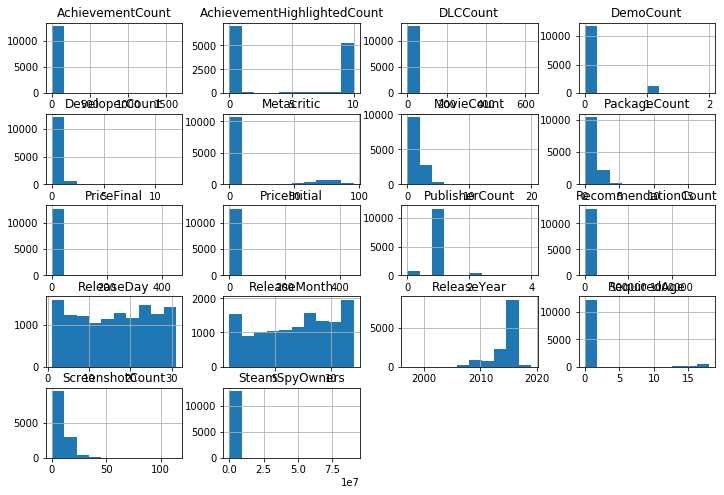

In [122]:
steam_viz.hist(figsize=(12,8))

Many features are strongly left skew on account of the fact that a game that does well is an exceptional thing.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f732b288ed0>,
      dtype=object)

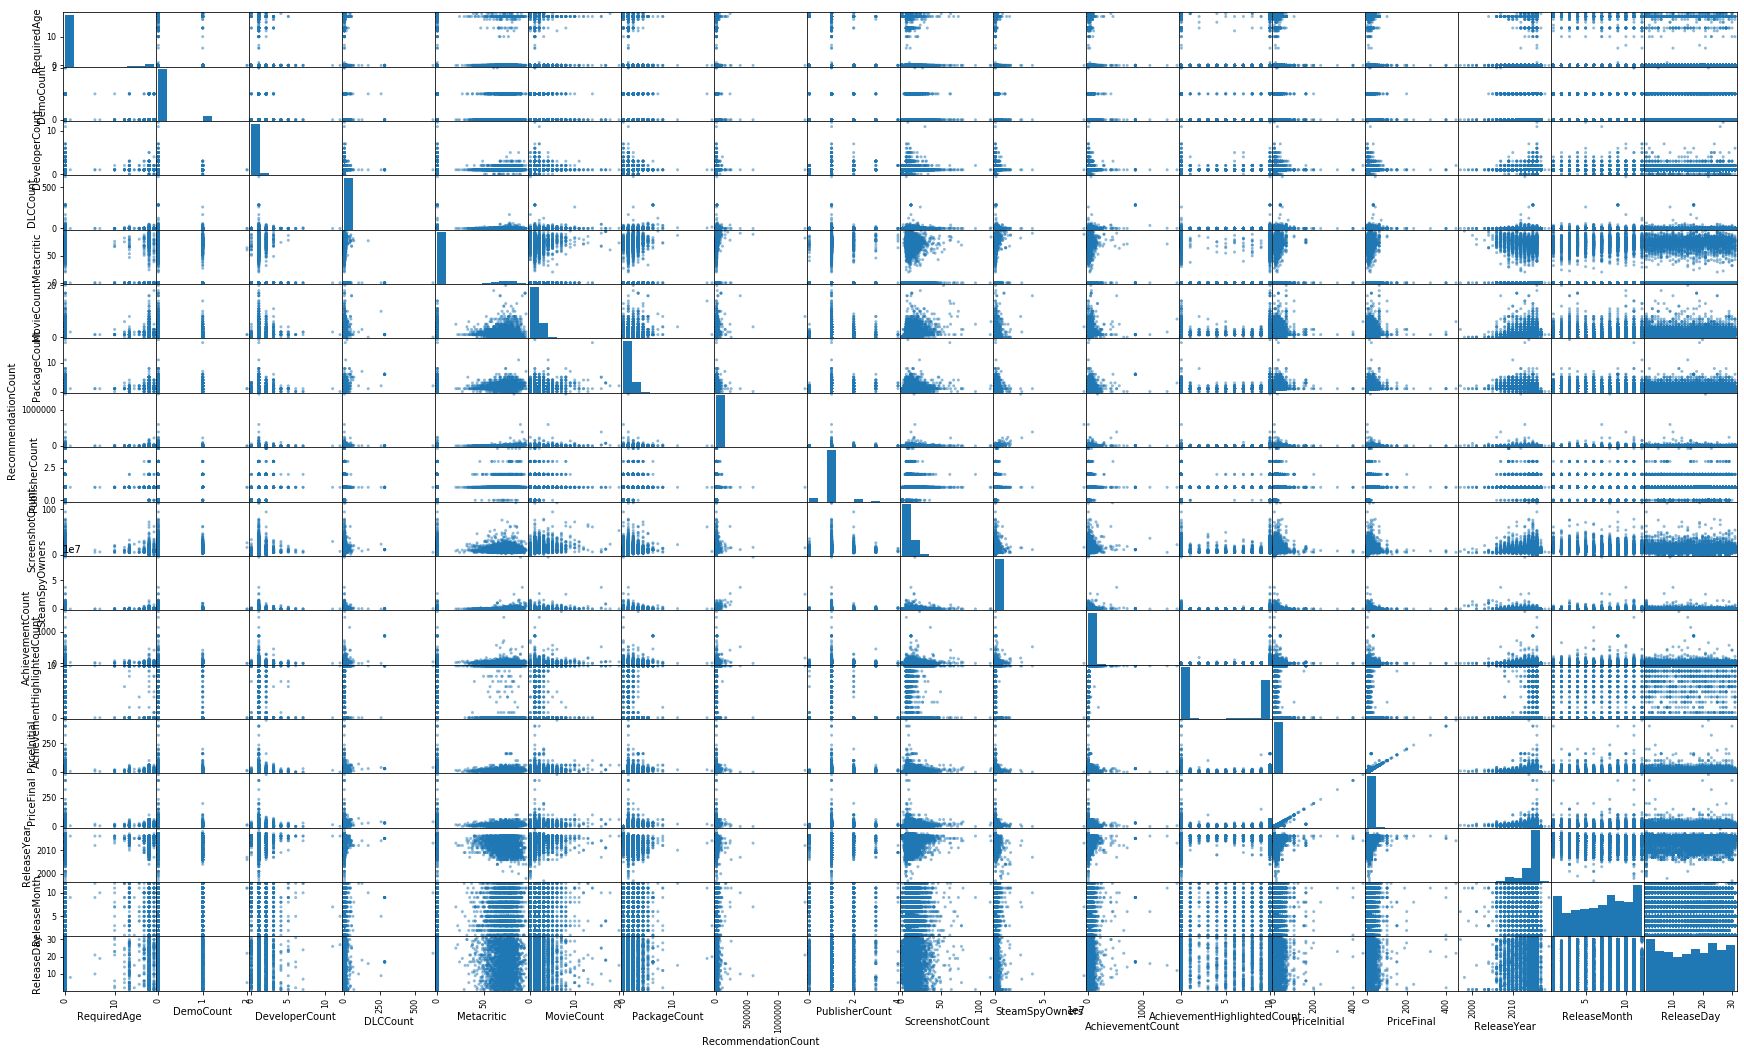

In [21]:
scatter_matrix(steam_viz, figsize=(30, 18))

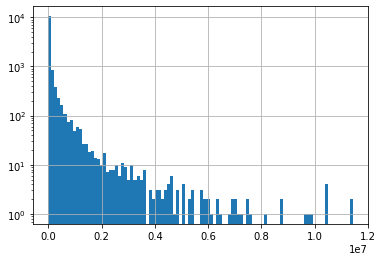

In [118]:
fig, ax = plt.subplots()
steam_viz['SteamSpyOwners'].hist(ax=ax, bins=100)
ax.set_yscale('log')

Those outliers should probably be removed.

In [14]:
# The inherent uncertainty in owner count _for each individual game_ is fairly low.
# This variance comes from stuff like free game giveways, game CD keys that have been sold but not necessarily claimed, game copies that have been sold but never played, etc. etc.
# This value acts as a sort of "lofty goal" to hit - even if our features were supernaturally descriptive and our model was perfect, it would still fail to reduce RMSE below this.
(np.mean(steam['SteamSpyOwnersVariance']))**(1/2)

74.07029465193224

In [17]:
print(np.min(steam['SteamSpyOwners']))
print(np.max(steam['SteamSpyOwners']))

0
90687580


In [94]:
def steam_preprocess(df):
    numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns

    steam_preprocessor = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numerical_ix),
    ], remainder='passthrough')
    
    return steam_preprocessor


In [125]:
steam_cleaned.shape

(12872, 53)

In [126]:
X = steam_cleaned.drop(['SteamSpyOwners'], axis=1)
y = steam_cleaned['SteamSpyOwners']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

X_train_unscaled = X_train
X_test_unscaled = X_test

ct = steam_preprocess(X_train)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

print(X_train.shape)

(10297, 52)


## Linear Regression Implementation and Comparison

Compares LinReg, a hand-implemented LinReg implementation, and SGDReg.

The former two use the normal equation for linear regression, while the latter uses gradient descent. Comparison of times, coefficients and scores (RMSE) is provided.

In [82]:
# No hyperparameter tuning

start = time.time()
reg = SGDRegressor(alpha=0, max_iter=10000).fit(X_train, y_train)
print("Time elapsed: ", time.time() - start)

reg.coef_

Time elapsed:  1.20595121383667


array([ 1.65605346e+05, -2.59034433e+05,  3.25151783e+05,  2.00003305e+05,
        3.63388775e+05,  2.26748848e+06, -3.71240534e+05,  1.22718220e+07,
        3.79507512e+05, -6.52855567e+04,  1.58974170e+06, -1.84480624e+04,
       -2.19479925e+05, -1.83072831e+05, -1.95403086e+06, -1.10907549e+04,
       -7.28016439e+04, -1.22304183e+04,  1.47992182e+05, -3.59805194e+05,
        2.27038330e+04, -5.23605124e+04,  8.12489699e+05,  2.11587088e+05,
        7.27771559e+04, -5.58186474e+03,  4.84609289e+04,  7.54855949e+03,
       -1.40790402e+05,  1.26521488e+04, -4.45353603e+04, -4.18054089e+05,
       -5.99777323e+04,  2.08488957e+05, -3.17884110e+04,  1.14711106e+06,
        2.69790578e+06,  9.66884389e+04,  1.21875839e+05, -3.20554232e+05,
       -8.18783585e+04,  1.25568837e+05,  6.58981867e+03,  2.27725421e+04,
       -2.74516281e+04,  1.92171783e+04,  5.25806666e+04,  3.05058140e+04,
        3.94766696e+05, -5.69348375e+04, -7.06896083e+04, -3.91482015e+05])

In [83]:
reg = LinearRegression().fit(X_train, y_train)

reg.coef_

array([ 7.56461525e+04, -1.52688460e+05,  3.48798228e+05, -6.51304399e+04,
        2.40187147e+05,  8.52253988e+05, -3.06589464e+05,  6.25954693e+07,
        3.27518526e+05, -1.06969439e+05,  9.21234776e+05, -1.06361745e+04,
        1.04508289e+05, -6.37206513e+05, -1.58565864e+06, -2.91386724e+04,
       -7.07106192e+04, -3.09671805e+04,  1.59895424e+05, -3.19749632e+05,
        1.77358819e+04, -1.92346838e+03, -6.58036770e+04,  1.62201595e+05,
        6.08913778e+04, -8.21429279e+04,  4.32664565e+04, -5.57853252e+04,
       -7.83650053e+04,  1.68617751e+04, -4.06928884e+04, -2.21971576e+05,
       -4.81333461e+04,  1.57414436e+05,  7.10343929e+04,  4.04852633e+05,
        2.48698854e+06,  4.37185789e+04,  7.36768985e+04, -1.43228875e+05,
       -5.24268691e+04,  1.00636289e+05,  1.82773742e+03,  6.37832475e+03,
       -5.42835224e+02,  5.04873491e+03,  3.04002883e+04,  2.47132874e+04,
        3.76975868e+05, -6.42186124e+03, -3.44353182e+04, -2.68425127e+05])

In [87]:
# Custom linear regression

class GhettoLinearRegression(BaseEstimator, RegressorMixin):
    coef_ = None
    
    def _pad_column(self, X): # Adds column of 1's at the beginning for the intercept
        X = as_numpy(X, dtype='float')
        return np.insert(X, 0, 1, axis=1)
        #return np.append(X, 1, axis=1)
    
    def fit(self, X, y):
        X = self._pad_column(X)
        self.coef_ = np.linalg.pinv(X.T.dot(X)).dot(X.T.dot(y))
        return self
    
    def predict(self, X):
        X = self._pad_column(X)
        return X.dot(self.coef_)
    
    def score(self, X, y):
        pred = self.predict(X)
        return (pred - y)**2

In [88]:
start = time.time()
reg = GhettoLinearRegression().fit(X_train, y_train)
print("Time elapsed: ", time.time() - start)

reg.coef_

Time elapsed:  0.008621454238891602


array([ 1.48752645e+06,  7.56461525e+04, -1.52688460e+05,  3.48798228e+05,
       -6.51304399e+04,  2.40187147e+05,  8.52253988e+05, -3.06589464e+05,
        6.25954693e+07,  3.27518526e+05, -1.06969439e+05,  9.21234776e+05,
       -1.06361745e+04,  1.04508289e+05, -6.37206513e+05, -1.58565864e+06,
       -2.91386724e+04, -7.07106192e+04, -3.09671805e+04,  1.59895424e+05,
       -3.19749632e+05,  1.77358819e+04, -1.92346838e+03, -6.58036772e+04,
        1.62201595e+05,  6.08913778e+04, -8.21429279e+04,  4.32664565e+04,
       -5.57853252e+04, -7.83650053e+04,  1.68617751e+04, -4.06928884e+04,
       -2.21971576e+05, -4.81333461e+04,  1.57414436e+05,  7.10343929e+04,
        4.04852633e+05,  2.48698854e+06,  4.37185789e+04,  7.36768985e+04,
       -1.43228875e+05, -5.24268691e+04,  1.00636289e+05,  1.82773742e+03,
        6.37832475e+03, -5.42835224e+02,  5.04873491e+03,  3.04002883e+04,
        2.47132874e+04,  3.76975868e+05, -6.42186124e+03, -3.44353182e+04,
       -2.68425127e+05])

In [24]:
def compareModels(models):
    for model in models:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
        print(type(model).__name__, "performance:", -np.mean(scores))
        

In [89]:
compareModels([LinearRegression(), GhettoLinearRegression(), SGDRegressor(alpha=0, max_iter=10000)])

LinearRegression performance: 1258156.2150331999
GhettoLinearRegression performance: 1258206.903153156
SGDRegressor performance: 1026670.0388078603


## Logistic Regression Regularization Comparison

In [97]:
clf = LogisticRegression()

scores = cross_val_score(clf, X_train_unscaled, y_train, cv=KFold(5), verbose=10, n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   46.8s remaining:  1.2min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:   46.8s remaining:   31.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   46.8s remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
scores

In [ ]:
search = GridSearchCV(LogisticRegression(), [
    {'penalty': ['l2', 'l1'], 'C': [0.001, 0.1, 1]},
    {'penalty': ['elasticnet'], 'C': [0.001, 0.1, 1], 'l1_ratio': [0.05, 0.5, 0.95]}
],scoring='neg_mean_squared_error', cv=KFold(2), n_jobs=4, verbose=10)

search = search.fit(X_train, y_train)

In [ ]:
search.best_params_

In [ ]:
search.cv_results_['mean_test_score'] # Getting the sense that logistic regression is not working very well for this dataset

## KNN Implementation

In [31]:
class GhettoKNN(BaseEstimator, RegressorMixin):
    def __init__(self, k=1, p=2):
        self.k_ = k
        self.p_ = p
        #self.scaler_ = StandardScaler()
    X_ = None
    y_ = None
    def dist(self, x1, x2):
        #print('x1:',  x1)
        #print('x2:', x2)
        ab = np.absolute(x2 - x1)
        #print('ab:', ab)
        pw = ab**self.p_
        #print('pw:', pw)
        sm = np.sum(pw, axis=1)
        #print('sm:', sm)
        fn = sm ** (1.0 / self.p_)
        #print('fn:', fn)
        return fn
    
    def fit(self, X, y):
        #self.X_ = self.scaler_.fit_transform(X.to_numpy(dtype='float'))
        self.X_ = as_numpy(X, dtype='float')
        #print(self.X_.shape)
        #print(len(self.X_))
        self.y_ = as_numpy(y)
        print(type(self.y_))
        return self
        
    def predict(self, X):
        X = as_numpy(X, dtype='float')
        #print(np.sum(X))
        # Go one example at a time
        predictions = []
        for example in X:
            #print(example)
            # Make an array of repeating examples
            t = np.tile(example, (np.size(self.X_, 0), 1))
            #print(t.shape)
            #print(example[0])
            # Calculate distance between example and all stored training examples
            distances = self.dist(t, self.X_)
            # Get indices of k smallest distances
            idx = np.argpartition(distances, self.k_)
            predictions.append(sum(self.y_[idx[:self.k_]]) / self.k_)
        return np.array(predictions)
    
    def get_params(self, deep):
        return dict(k=self.k_, p=self.p_)


In [32]:
reg = GhettoKNN()
reg.fit(X_train, y_train)

<class 'numpy.ndarray'>


GhettoKNN(k=1, p=2)

In [33]:
predictions = reg.predict(X_train)
predictions[:100]

array([1.07700e+03, 0.00000e+00, 7.28160e+04, 0.00000e+00, 1.96567e+05,
       1.32360e+05, 6.45700e+03, 2.22390e+04, 2.52880e+04, 0.00000e+00,
       1.48860e+04, 1.60500e+03, 3.60490e+04, 3.58700e+03, 1.38100e+04,
       3.40760e+04, 8.14606e+05, 0.00000e+00, 2.06252e+05, 0.00000e+00,
       3.69460e+04, 5.35000e+02, 4.37610e+04, 7.85550e+04, 9.50600e+03,
       0.00000e+00, 3.12786e+05, 4.05330e+04, 1.17456e+06, 1.02230e+04,
       7.83760e+04, 0.00000e+00, 6.52653e+05, 4.66300e+03, 0.00000e+00,
       0.00000e+00, 1.43500e+03, 4.57340e+04, 0.00000e+00, 1.61400e+03,
       0.00000e+00, 5.02200e+03, 4.48400e+03, 8.55500e+04, 1.20160e+04,
       1.07600e+03, 9.77460e+04, 3.76600e+03, 7.89100e+03, 0.00000e+00,
       4.12500e+03, 1.97300e+03, 3.33590e+04, 1.43480e+04, 2.15200e+03,
       5.77510e+04, 1.90110e+04, 5.91900e+03, 2.56470e+04, 0.00000e+00,
       1.05820e+04, 0.00000e+00, 4.42990e+04, 3.39509e+05, 1.00440e+04,
       2.69000e+03, 0.00000e+00, 1.79300e+03, 1.43500e+03, 0.000

In [34]:
y_train[:100]

8875       1077
7792          0
4427      72816
12389         0
4684     196567
          ...  
9740      11299
2344     235665
11424      3946
7195       3408
75       312427
Name: SteamSpyOwners, Length: 100, dtype: int64

In [35]:
reg = KNeighborsRegressor(n_neighbors=2).fit(X, y)

reg.predict(X_train)[:100]

array([95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593.])

In [36]:
reg = GhettoKNN(k=2).fit(X, y)

reg.predict(X_train)[:100]

<class 'numpy.ndarray'>


array([95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593., 95593., 95593., 95593., 95593.,
       95593., 95593., 95593., 95593.])

In [37]:
models = [GhettoKNN(k=5, p=2), KNeighborsRegressor(n_neighbors=5)]

# Compare predictions of hand-implementation to library
for reg in models:
    reg.fit(X_train, y_train)
    predictions = reg.predict(X_train)
    print(predictions[:20])

<class 'numpy.ndarray'>
[1.8509000e+04 3.9959000e+04 2.7297000e+04 5.9544000e+04 1.7918458e+06
 3.3215600e+04 7.8904000e+03 7.8770200e+04 2.5492740e+05 1.6392400e+04
 9.4804200e+04 2.4676800e+04 9.1108000e+03 1.0717920e+05 4.8101600e+04
 2.5216400e+04 4.1670080e+05 1.0394000e+03 8.6625800e+04 0.0000000e+00]
[1.8509000e+04 3.9959000e+04 2.7297000e+04 5.9544000e+04 1.7918458e+06
 3.3215600e+04 7.8904000e+03 7.8770200e+04 2.5492740e+05 1.6392400e+04
 9.4804200e+04 2.4676800e+04 9.1108000e+03 1.0717920e+05 4.8101600e+04
 2.5216400e+04 4.1670080e+05 1.0394000e+03 8.6625800e+04 0.0000000e+00]


In [38]:
# Compare performance
compareModels(models)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
GhettoKNN performance: 981778.3355074184
KNeighborsRegressor performance: 981725.7355413493


## Boosting

In [115]:
import xgboost as xgb

xdg_X_train, xdg_X_test, xdg_y_train, xdg_y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

In [128]:
d_train = xgb.DMatrix(xdg_X_train, label=xdg_y_train)
d_test = xgb.DMatrix(xdg_X_test, label=xdg_y_test)

param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror'}

num_round = 27

evallist = [(d_test, 'eval'), (d_train, 'train')]

bst = xgb.train(param, d_train, num_round, evallist)

[0]	eval-rmse:228943.23438	train-rmse:215937.40625
[1]	eval-rmse:213156.82812	train-rmse:200299.98438
[2]	eval-rmse:191483.21875	train-rmse:190280.95312
[3]	eval-rmse:192079.71875	train-rmse:182072.62500
[4]	eval-rmse:192579.98438	train-rmse:178422.48438
[5]	eval-rmse:188348.51562	train-rmse:174251.46875
[6]	eval-rmse:187635.46875	train-rmse:172602.71875
[7]	eval-rmse:189261.18750	train-rmse:170965.03125
[8]	eval-rmse:188975.12500	train-rmse:170076.40625
[9]	eval-rmse:190478.46875	train-rmse:167476.79688
[10]	eval-rmse:186117.12500	train-rmse:165995.56250
[11]	eval-rmse:185371.89062	train-rmse:164369.09375
[12]	eval-rmse:179656.90625	train-rmse:162058.28125
[13]	eval-rmse:181260.81250	train-rmse:159151.59375
[14]	eval-rmse:180135.43750	train-rmse:157202.50000
[15]	eval-rmse:180754.76562	train-rmse:155783.40625
[16]	eval-rmse:180436.96875	train-rmse:152098.78125
[17]	eval-rmse:180550.12500	train-rmse:151437.35938
[18]	eval-rmse:180541.84375	train-rmse:150249.10938
[19]	eval-rmse:179331.

In [129]:
scores = pd.DataFrame({
    'model': ['Linear Regression', 'SGDRegressor', 'K-Nearest Neighbors', 'XGBoost'],
    'score (RMSE)': [1258156, 1026670, 981725, 168644]
})

Text(0, 0.5, 'RMSE')

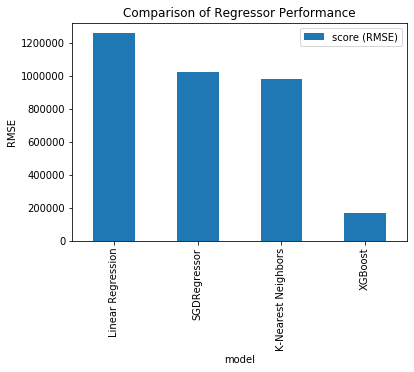

In [130]:
scores.plot.bar(x='model', y='score (RMSE)', title='Comparison of Regressor Performance')
plt.ylabel('RMSE')

In [113]:
from sklearn.ensemble import AdaBoostRegressor

reg = AdaBoostRegressor(loss='linear', n_estimators=1000, learning_rate=0.5)

scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error')

In [114]:
-np.mean(scores)

75721544505.78336